<a href="https://colab.research.google.com/github/stepan-zykov/DLS/blob/main/generative_models_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt

import seaborn as sns

In [2]:
import os

In [3]:
master_url_root = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'
df_small_noise_url_suffix = 'artificialNoAnomaly/art_daily_small_noise.csv'
df_small_noise_url = os.path.join(master_url_root, df_small_noise_url_suffix)

In [4]:
df_small_noise = pd.read_csv(df_small_noise_url, parse_dates=True, index_col="timestamp")

In [5]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [6]:
df_daily_jumpsup_url_suffix = 'artificialWithAnomaly/art_daily_jumpsup.csv'
df_daily_jumpsup_url = os.path.join(master_url_root, df_daily_jumpsup_url_suffix)

In [7]:
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col="timestamp")

In [8]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [9]:
df_daily_jumpsup.shape

(4032, 1)

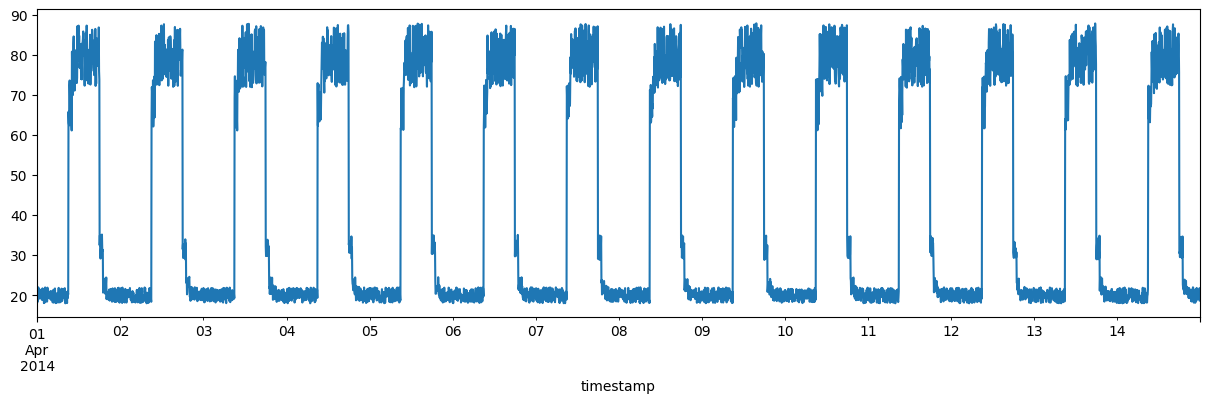

In [10]:
fig, ax = plt.subplots(figsize=(15, 4))
df_small_noise.plot(legend=False, ax=ax)
plt.show()

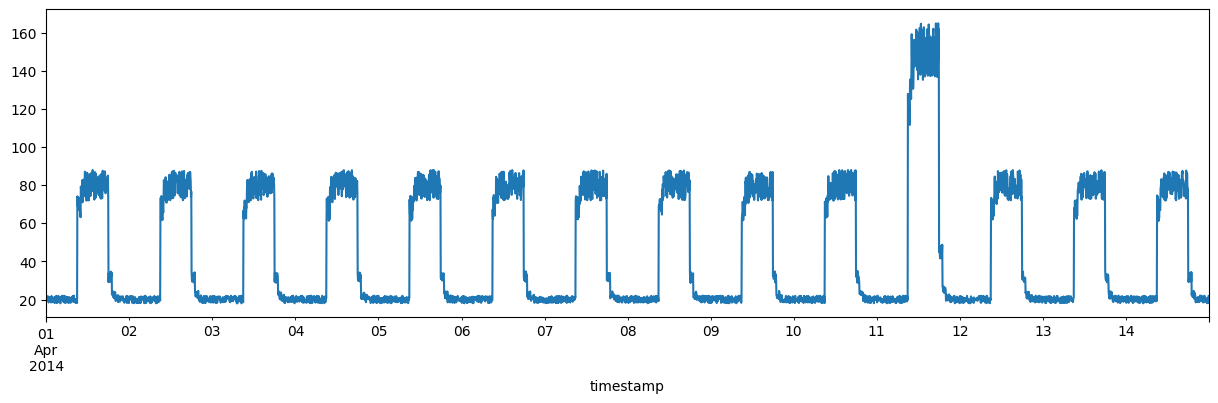

In [11]:
fig, ax = plt.subplots(figsize=(15, 4))
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [12]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std

In [13]:
24*60 / 5

288.0

In [14]:
TIME_STAMPS = 288

def create_sequences(values, time_stamps=TIME_STAMPS):
    output = []
    for i in range(len(values) - time_stamps):
        output.append(values[i : i + time_stamps])
    return torch.FloatTensor(output).permute(0, 2, 1)

In [15]:
X = create_sequences(df_training_value.values)

<ipython-input-14-7ba5c92bc14a>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.FloatTensor(output).permute(0, 2, 1)


In [16]:
x_train, x_val = train_test_split(X, test_size=0.9, shuffle=False)

In [17]:
x_train.shape

torch.Size([374, 1, 288])

In [18]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=4)
val_loader = torch.utils.data.DataLoader(x_train, batch_size=4)

In [26]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(16, 16, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, kernel_size=7, stride=1, padding=3),
        )

    def forward(self, sample):
        latent = self.encoder(sample)
        reconstructed = self.decoder(latent)
        return reconstructed

In [67]:
n_epochs = 50
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
            reconstructed = model(X_batch.to(device))
            loss = loss_fn(reconstructed, X_batch.to(device))
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-67-cb825d181dde>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

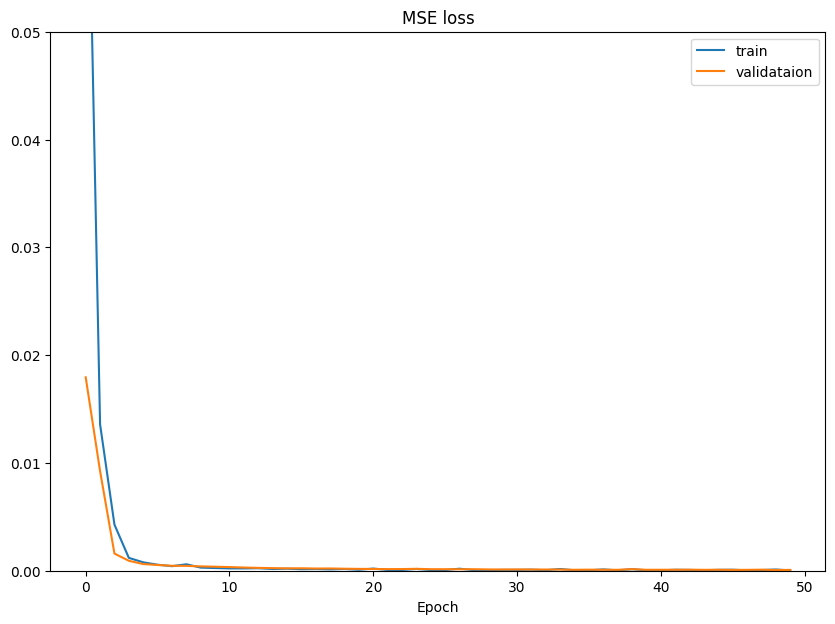

In [68]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot(np.arange(len(val_losses)), val_losses, label='validataion')

plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [69]:
X_loader = torch.utils.data.DataLoader(X, batch_size=1)
model.eval()
threshold = 0.0
x_pred = []

with torch.no_grad():
    for batch in X_loader:
        pred = model(batch.to(device)).cpu().numpy()
        x_pred.append(pred.ravel())
        mae_loss = np.mean(np.abs(pred - batch.numpy()))

        if mae_loss > threshold:
            threshold = mae_loss

print('Reconstruction error threshold: ', threshold)

Reconstruction error threshold:  0.007369337


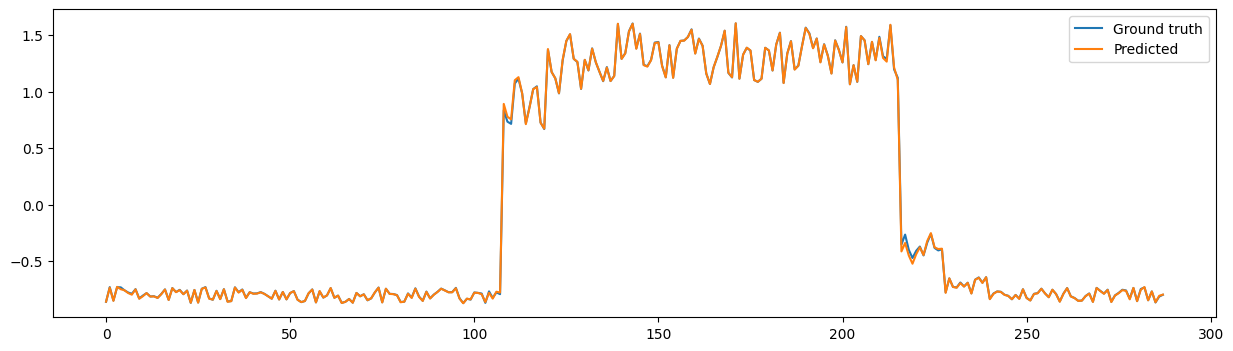

In [70]:
plt.figure(figsize=(15, 4))
plt.plot(x_train[0].numpy().ravel(), label='Ground truth')
plt.plot(x_pred[0], label='Predicted')

plt.legend()
plt.show()

In [71]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std

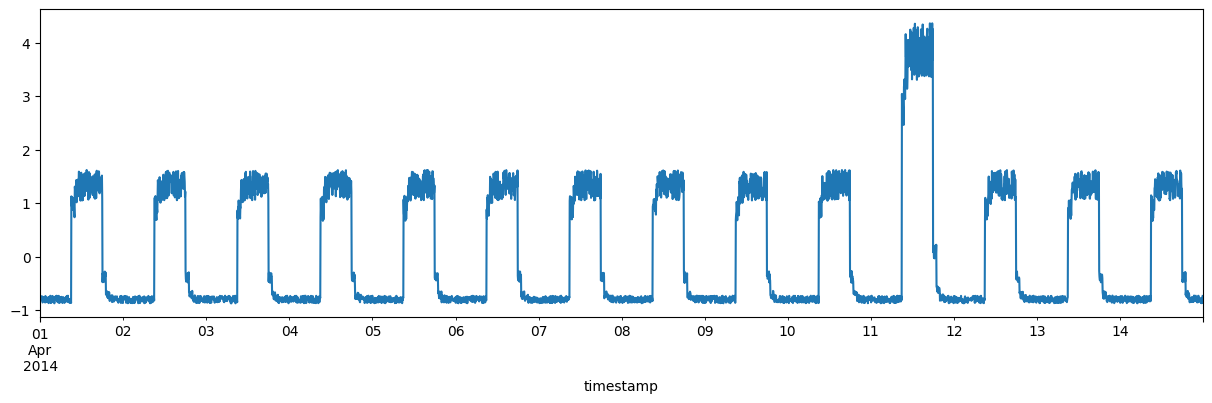

In [72]:
fig, ax = plt.subplots(figsize=(15, 4))
df_test_value.plot(legend=False, ax=ax)
plt.show()

In [84]:
x_test = create_sequences(df_test_value.values)
test_loader = torch.utils.data.DataLoader(x_test, shuffle=False)
print('Test input shape: ', x_test.shape)

Test input shape:  torch.Size([3744, 1, 288])


In [85]:
test_losses = []
with torch.no_grad():
    for batch in test_loader:
        pred = model(batch.to(device)).cpu().numpy()
        mae_loss = np.mean(np.abs(pred - batch.numpy()))
        test_losses.append(mae_loss)

In [86]:
test_losses = np.array(test_losses).reshape((-1))

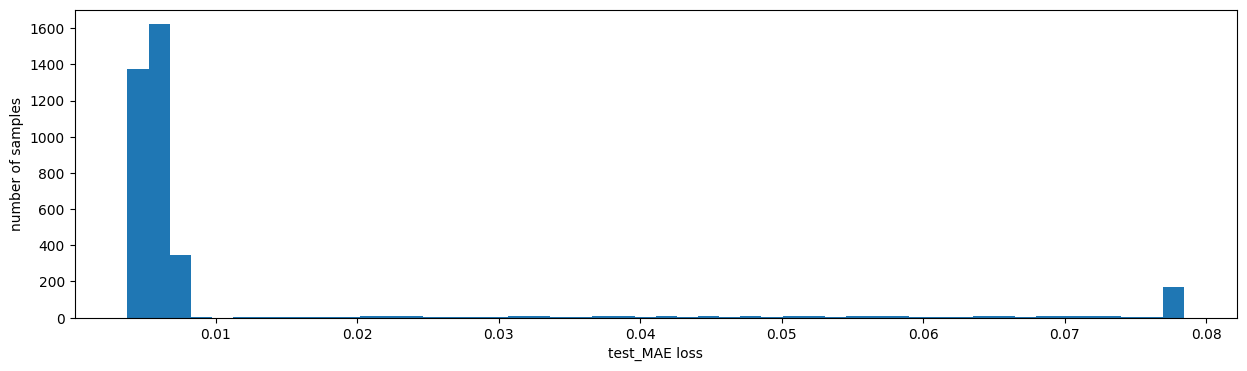

In [87]:
plt.figure(figsize=(15, 4))
plt.hist(test_losses, bins=50)
plt.xlabel('test_MAE loss')
plt.ylabel('number of samples')
plt.show()

In [88]:
anomalies = test_losses > threshold

In [89]:
print('Number of anomaly samples: ', np.sum(anomalies))
print('Indices of anomaly samples: ', np.where(anomalies))

Number of anomaly samples:  473
Indices of anomaly samples:  (array([ 123,  124,  134,  183,  185,  195,  220,  407,  408,  409,  411,
        412,  413,  418,  420,  422,  425,  427,  428,  429,  431,  432,
        434,  435,  437,  438,  439,  440,  441,  442,  443,  445,  447,
        448,  449,  450,  452,  453,  455,  460,  462,  464,  465,  468,
        470,  471,  477,  487,  489,  493,  499,  511,  765,  775,  778,
        782, 2140, 2141, 2143, 2144, 2146, 2150, 2153, 2155, 2156, 2158,
       2160, 2163, 2166, 2181, 2184, 2200, 2701, 2702, 2703, 2704, 2705,
       2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716,
       2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727,
       2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738,
       2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749,
       2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760,
       2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2

In [90]:
abnormal_data_indices = []
for data_idx in range(TIME_STAMPS - 1, len(df_test_value) - TIME_STAMPS + 1):
    if np.all(anomalies[data_idx - TIME_STAMPS + 1 : data_idx]):
        abnormal_data_indices.append(data_idx)

In [91]:
len(abnormal_data_indices)

115

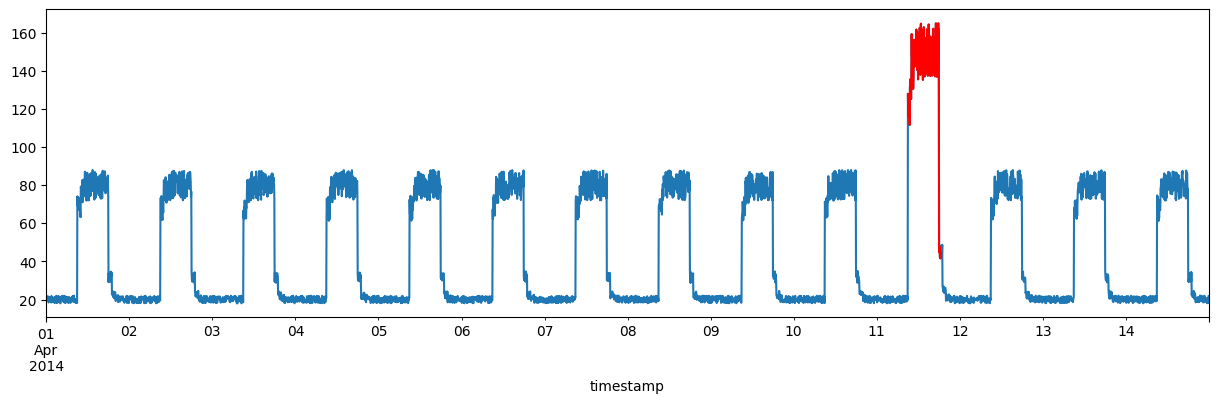

In [94]:
df_subset = df_daily_jumpsup.iloc[abnormal_data_indices]
fig, ax = plt.subplots(figsize=(15, 4))
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color='red')
plt.show()